In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [277]:
cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)


optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle


In [301]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier



def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 5

Xl, Xs, yl, ys = [], [], [], []
for btest in btests:
    print(btest.cfg.ticker)
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize)
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fc = f.Close[:-1]#/f.Close[-2]
        fo = f.Open[:-1]#/f.Open[-2]
        fh = f.High[:-1]#/f.High[-2]
        fl = f.Low[:-1]#/f.Low[-2]
        fv = f.Volume[:-1]#/f.Volume[-2]
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, 1]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([fc, fo, fl, fh, fv, -1])) 
            ys.append(pos.profit)           
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)

ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
Xs = np.vstack([Xs, Xs[ids2add]])
ys = np.hstack([ys, ys[ids2add]])
X = Xl[:, :-1]#np.vstack([Xs, Xl])
y = yl#np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

SBER
ROSN
LKOH
GMKN
GAZP
(2164, 21) (2164, 21) (2164, 20) (2164,) (2164,) (2164,)


In [306]:
nitrers = 10
test_size = 0.3

profits, metrics = np.zeros((2, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    profs = y_test
    y_train = (y_train > 0).astype(int)
    y_test = (y_test > 0).astype(int)

    scaler = StandardScaler() 
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test) 
    
    # X_add = X_train + np.random.random(X_train.shape)*0.1
    # X_train = np.vstack([X_train, X_add])
    # y_train = np.hstack([y_train, y_train])

    # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=3,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=1000,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # # lgb.plot_metric(evals_result, metric='f1')
    # p_train = model.predict(X_train)
    # p_test = model.predict(X_test)
    
    model = RandomForestClassifier(max_depth=15, n_estimators=50, min_samples_split=2, class_weight="balanced")
    model.fit(X_train, y_train)
    p_train = model.predict_proba(X_train)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]
    
    threshold = np.percentile(p_train, 10)#np.mean(p_train)
    metrics[0, i] = f1_score(p_train > threshold, y_train)
    metrics[1, i] = f1_score(p_test > threshold, y_test)
    
    # plt.figure(figsize=(20, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(p_train[:100])
    # plt.plot(y_train[:100])
    # plt.plot([0, 100], [threshold, threshold])
    # plt.subplot(1, 2, 2)
    # plt.plot(p_test[:100])
    # plt.plot(y_test[:100])
    # plt.plot([0, 100], [threshold, threshold])

    profits[0, i] = profs.sum()
    profits[1, i] = (profs*(p_test>=threshold)).sum()
    print(f"{i:03} f1_train: {metrics[0, i]:4.2f}, f1_test: {metrics[1, i]:4.2f}, profit:{profits[0, i]:+6.1f} -> {profits[1, i]:+6.1f} {'OK' if profits[1, i] > profits[0, i] else '--'}")

000 f1_train: 0.50, f1_test: 0.47, profit:+181.5 -> +149.9 --
001 f1_train: 0.50, f1_test: 0.48, profit:+248.7 -> +214.6 --
002 f1_train: 0.50, f1_test: 0.49, profit:+229.3 -> +232.3 OK
003 f1_train: 0.51, f1_test: 0.46, profit:+235.2 -> +166.8 --
004 f1_train: 0.52, f1_test: 0.46, profit:+125.2 -> +115.1 --
005 f1_train: 0.52, f1_test: 0.44, profit: +90.6 ->  +56.4 --
006 f1_train: 0.51, f1_test: 0.47, profit:+166.8 -> +158.7 --
007 f1_train: 0.51, f1_test: 0.47, profit:+195.4 -> +173.2 --
008 f1_train: 0.51, f1_test: 0.46, profit:+266.8 -> +235.7 --
009 f1_train: 0.51, f1_test: 0.46, profit:+288.2 -> +286.5 --


In [305]:
prof_, prof = profits.mean(1)
print(prof_, prof, (prof - prof_)/abs(prof_))
prof_, prof = metrics.mean(1)
print(prof_, prof, (prof - prof_)/abs(prof_))

212.08281796072015 200.31022136290468 -0.05550943122604051
0.5100992733527743 0.4630462103391263 -0.09224295244409618


In [8]:
print((p_test>0.5).astype(int)[:30])
print(y_test[:30])
print(y_test[:30]*(p_test>0.5).astype(int)[:30])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [65]:
opt_summary = {k:[] for k in cfgs[0].keys()}
for k in opt_summary.keys():
    for cfg in cfgs:
        v = cfg[k]
        if type(v) is EasyDict and "func" in v.keys():
            opt_summary[k].append(str(v.func.name))
        else:
            opt_summary[k].append(v)
            
opt_summary["btest"], opt_summary["ndeals"] = [], []
for btest in btests:
    opt_summary["btest"].append(btest.profits.sum())
    opt_summary["ndeals"].append(len(btest.profits))
    
opt_summary = pd.DataFrame(opt_summary)
opt_summary.sort_values(by=["btest"], ascending=False, inplace=True)
opt_summary = opt_summary[opt_summary.ticker != "NVTK"]
opt_summary.head(10)

,date_start,trailing_stop_rate,trailing_stop_type,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,btest,ndeals
0,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,SBER,metatrader,False,96.848627,325
1,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,ROSN,metatrader,False,95.741142,238
3,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,LKOH,metatrader,False,44.861520,236
5,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,GAZP,metatrader,False,9.741738,201
4,2008-01-01,0.01,1,trend:3,stops_dyn:False-True,9999,30,0,None,H1,GMKN,metatrader,False,-18.667569,229


In [97]:
opt_res = {"param_set":[], "ticker":[], "btest":[], "ndeals":[], "test_ids":[]}
for i in range(opt_summary.shape[0]):
    exphash, test_ids = "", ""
    for col in opt_summary.columns:
        if col not in ["ticker", "btest", "ndeals"]:
            exphash += str(opt_summary[col].iloc[i]) + " "
    opt_res["test_ids"].append(f".{opt_summary.index[i]}")
    opt_res["param_set"].append(exphash)
    opt_res["ticker"].append(f".{opt_summary.ticker.iloc[i]}")
    opt_res["ndeals"].append(opt_summary.ndeals.iloc[i])
    opt_res["btest"].append(opt_summary.btest.iloc[i])

opt_res = pd.DataFrame(opt_res)
opt_res = opt_res.groupby(by="param_set").sum()
opt_res.sort_values(by=["btest"], ascending=False, inplace=True)
opt_res.head(20)

,ticker,btest,ndeals,test_ids
param_set,,,,
"0.01 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.GAZP.ROSN.LKOH.GMKN,1281.555675,7363,.78.83.79.81.82
"0.02 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.ROSN.GAZP.GMKN.LKOH,1199.089473,10116,.150.151.155.154.153
"0.01 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M5 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,1170.594524,20953,.84.89.85.88.87
"0.04 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,1016.295944,11879,.222.227.223.226.225
"0.01 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None H1 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,825.928107,2097,.72.77.73.76.75
"0.02 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M5 metatrader False",.GAZP.SBER.ROSN.GMKN.LKOH,752.132820,28537,.161.156.157.160.159
"0.02 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None H1 metatrader False",.SBER.ROSN.GAZP.LKOH.GMKN,735.021045,2896,.144.145.149.147.148
"0.04 2 trend:npairs=2 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None H1 metatrader False",.ROSN.SBER.GAZP.LKOH.GMKN,729.196327,3905,.217.216.221.219.220
"0.01 2 trend:npairs=3 stops_dyn:tp_active=False,sl_active=True 9999 30 0 None M15 metatrader False",.SBER.GAZP.ROSN.GMKN.LKOH,668.375233,5562,.96.101.97.100.99


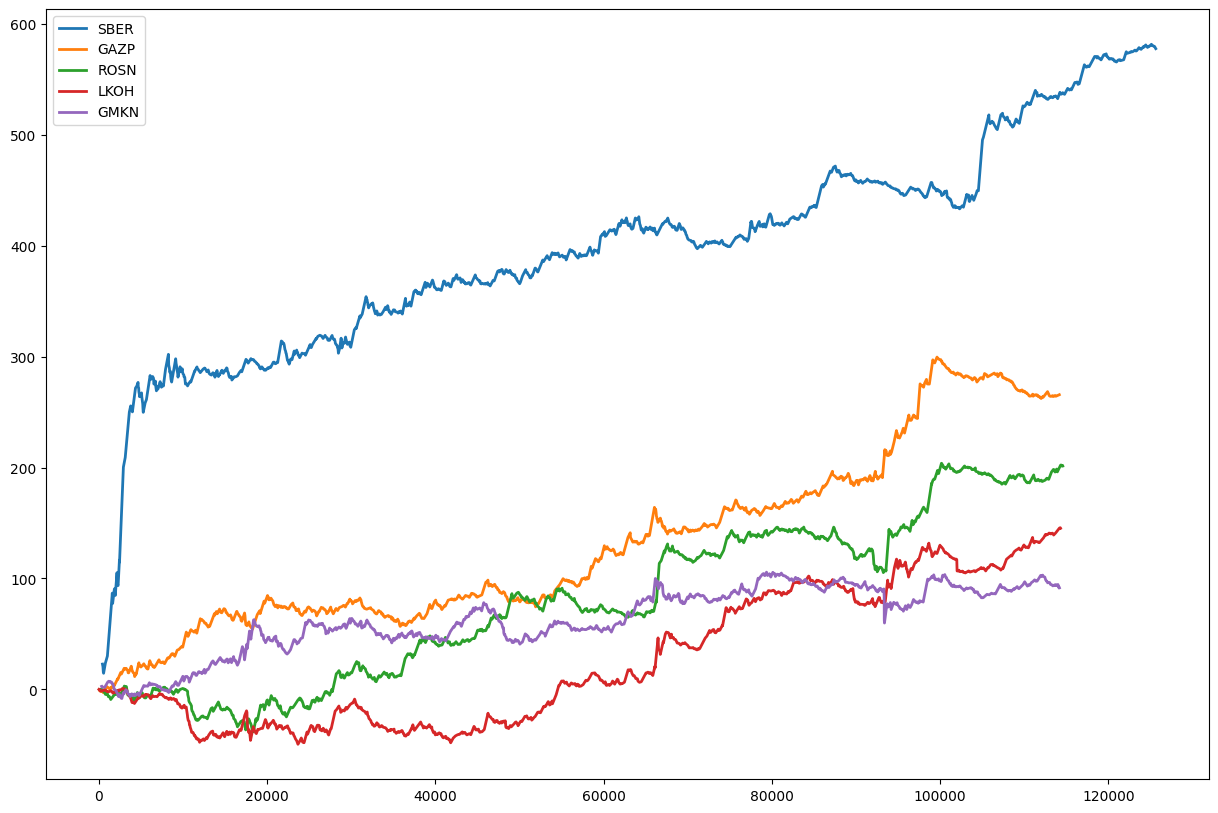

In [98]:
plt.figure(figsize=(15, 10))
opt_res_id = 0
legend = []
for test_id in map(int, opt_res.test_ids.iloc[opt_res_id].split(".")[1:]):
    plt.plot([pos.close_date for pos in btests[test_id].positions], 
             btests[test_id].profits.cumsum(), 
             linewidth=2)
    legend.append(cfgs[test_id].ticker)
plt.legend(legend)

In [18]:
opt_summary_loc = opt_summary[opt_summary.ticker == "ROSN"]
opt_summary_loc.head()

,trailing_stop_rate,trailing_stop_type,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,btest,ndeals
475,0.04,1,trend:npairs=2,"stops_fix:tp=25,sl=8",9999,30,0,None,M15,ROSN,metatrader,False,352.311404,1094
67,0.01,1,trend:npairs=3,"stops_fix:tp=25,sl=2",9999,30,0,None,M5,ROSN,metatrader,False,318.463341,1410
391,0.02,1,trngl_comp:npairs=3,"stops_fix:tp=25,sl=2",9999,30,0,None,M5,ROSN,metatrader,False,309.361871,2274
283,0.02,1,trend:npairs=3,"stops_fix:tp=25,sl=2",9999,30,0,None,M5,ROSN,metatrader,False,299.720672,1886
457,0.04,1,trend:npairs=2,"stops_fix:tp=25,sl=4",9999,30,0,None,M15,ROSN,metatrader,False,296.919481,1284
